In [3]:
import nltk
import requests
import warnings
from sqlalchemy import text
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Data manipulation and analysis
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sqlalchemy.orm import sessionmaker
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

# Financial data extraction
import yfinance as yf

# SQL Alchemy for database interaction
from sqlalchemy import create_engine

# Additional libraries for analysis or visualization
import matplotlib.pyplot as plt
import seaborn as sns
from config import api_key

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [4]:
warnings.filterwarnings('ignore')

In [5]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetches historical stock prices for the specified ticker within the given timeframe.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data


In [6]:
def fetch_all_stock_data(tickers, start_date, end_date):
    stock_data = {}
    for ticker in tickers:
        print(f"Fetching data for {ticker}")
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [7]:
def calculate_daily_return(stock_data):
    """
    Calculates the daily return from the closing prices.
    """
    stock_data['Daily_Return'] = stock_data['Close'].pct_change()
    return stock_data


In [8]:
def load_data_to_db(data, ticker):
    """
    Loads transformed data into the SQLite database.
    """
    engine = create_engine('sqlite:///stock_market_analysis.sqlite')
    data.to_sql(ticker, con=engine, if_exists='replace', index=True)


In [9]:
def read_data(ticker):
    """
    Reads the data for the specified ticker from the SQLite database.
    """
    engine = create_engine('sqlite:///stock_market_analysis.sqlite')
    # engine = create_engine('sqlite:///stock_market_analysis.db')
    query = f"SELECT * FROM '{ticker}'"
    data = pd.read_sql_query(query, con=engine)
    return data


In [10]:
def plot_moving_averages(stock_data, ticker):
    data = stock_data[ticker]
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price', alpha=0.5)
    plt.plot(data['SMA_50'], label='50-Day SMA')
    plt.plot(data['SMA_200'], label='200-Day SMA')
    plt.title(f"{ticker} - Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()

In [11]:
def predict_monthly_prices(model, last_known_price, last_known_date, months=36):
    future_prices = []
    future_dates = []
    current_price = last_known_price
    
    for month in range(months):
        # Approximating each month by 21 trading days
        for day in range(21):
            next_input = pd.DataFrame(data=[[current_price]], columns=['Previous Close'])
            current_price = model.predict(next_input)[0]
        
        future_prices.append(current_price)
        # Assuming last_known_date is a datetime object; add roughly 30 days for each month
        last_known_date += timedelta(days=30)
        future_dates.append(last_known_date)
    
    return future_dates, future_prices

In [12]:
def train_model_for_ticker(ticker_data):
    """
    Trains a LinearRegression model for the given ticker data.
    """
    data = ticker_data[['Close']].copy()
    data['Previous Close'] = data['Close'].shift(1)
    data.dropna(inplace=True)  # Drop the first row which now contains NaN

    X = data[['Previous Close']]  # Features
    y = data['Close']  # Target

    model = LinearRegression()
    model.fit(X, y)  # Training the model
    return model

In [13]:
# Objective Function (Negative Sharpe Ratio)
def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.01):
    p_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    p_ret = np.dot(weights, expected_returns)
    return -(p_ret - risk_free_rate) / np.sqrt(p_var)

In [14]:
def fetch_news(api_key, ticker):
    """Fetch news articles related to a specific stock ticker using NewsAPI."""
    base_url = "https://newsapi.org/v2/everything"
    params = {
        'q': ticker,             # Search query (ticker symbol)
        'sortBy': 'publishedAt', # Sort by publication date
        'apiKey': api_key        # Your NewsAPI key
    }
    response = requests.get(base_url, params=params)
    return response.json()  # Returns the JSON response converted to a dictionary

In [15]:
def analyze_sentiment(text):
    """Analyze the sentiment of a text and return polarity and subjectivity."""
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [16]:
def main():
    tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']

    for ticker in tickers:
        print(f"Fetching news for: {ticker}")
        articles = fetch_news(api_key, ticker)
        if articles['status'] == 'ok':
            for article in articles['articles'][:5]:  # Show only the first 5 articles for brevity
                description = article.get('description') or article.get('title')
                polarity, subjectivity = analyze_sentiment(description)
                print(f"Ticker: {ticker}, Title: {article['title']}")
                print(f"Sentiment Polarity: {polarity:.2f}, Sentiment Subjectivity: {subjectivity:.2f}")
                print(f"URL: {article['url']}\n")
        else:
            print(f"Failed to fetch articles for {ticker}")
        print("=" * 50)  # Separator for clarity between tickers

In [17]:
text('test')

In [18]:
# Create engine
engine = create_engine('sqlite:///stock_market_analysis.sqlite')
# engine = create_engine('sqlite:///stock_market_analysis.db')

# Create session
Session = sessionmaker(bind=engine)
session = Session()

# Specify your ticker variable correctly
ticker = 'AAPL'  # example ticker

# Execute query using the text function for raw SQL
query = text(f"SELECT * FROM {ticker}")
result = session.execute(query)

# Fetch data as DataFrame
data = pd.DataFrame(result.fetchall(), columns=result.keys())

# It's important to close the session after use
session.close()

# Display the dataframe or process further as needed
data.head()



,index,Average Sentiment Score
0,MSFT,0.033303
1,CRM,0.022510
2,CRWD,0.091855
3,ZM,0.020036
4,SHOP,0.168199


In [19]:
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP','AAPL']
start_date = '2020-01-01'
end_date = '2024-01-01'


all_stock_data = fetch_all_stock_data(tickers, start_date, end_date)

Fetching data for MSFT


[*********************100%%**********************]  1 of 1 completed


Fetching data for CRM


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for CRWD
Fetching data for ZM


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for SHOP
Fetching data for AAPL


[*********************100%%**********************]  1 of 1 completed


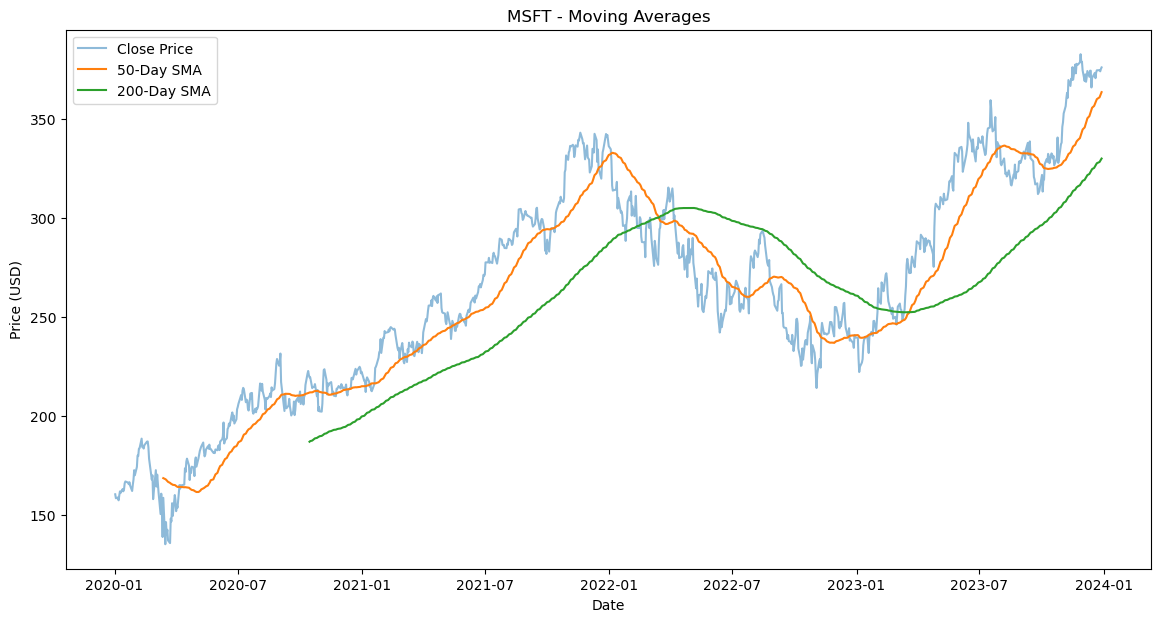

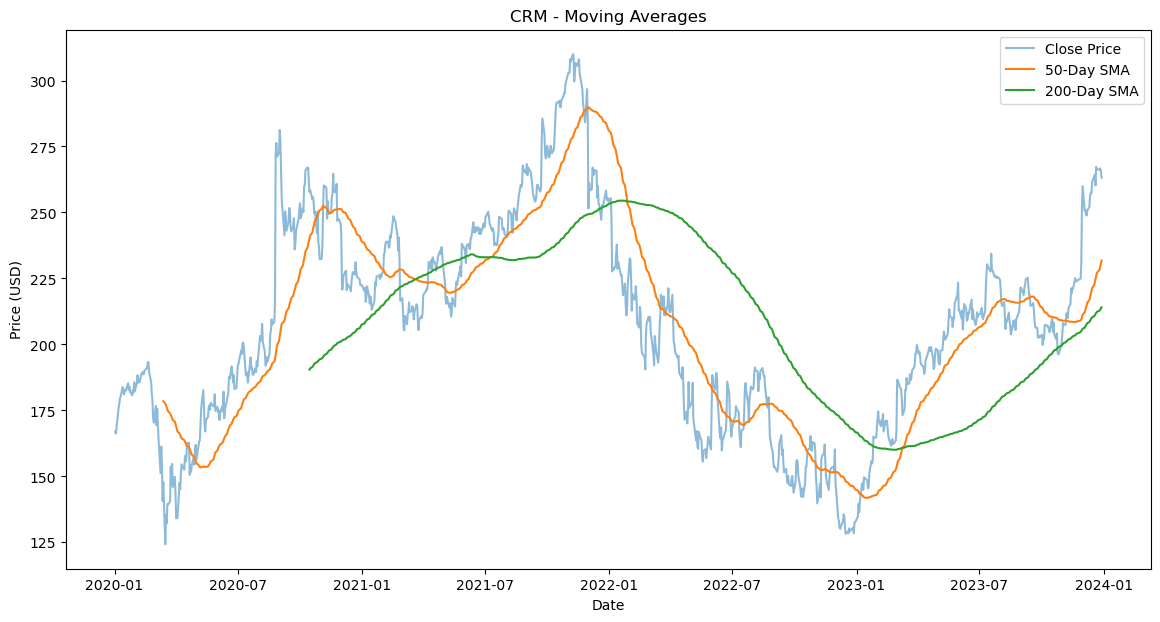

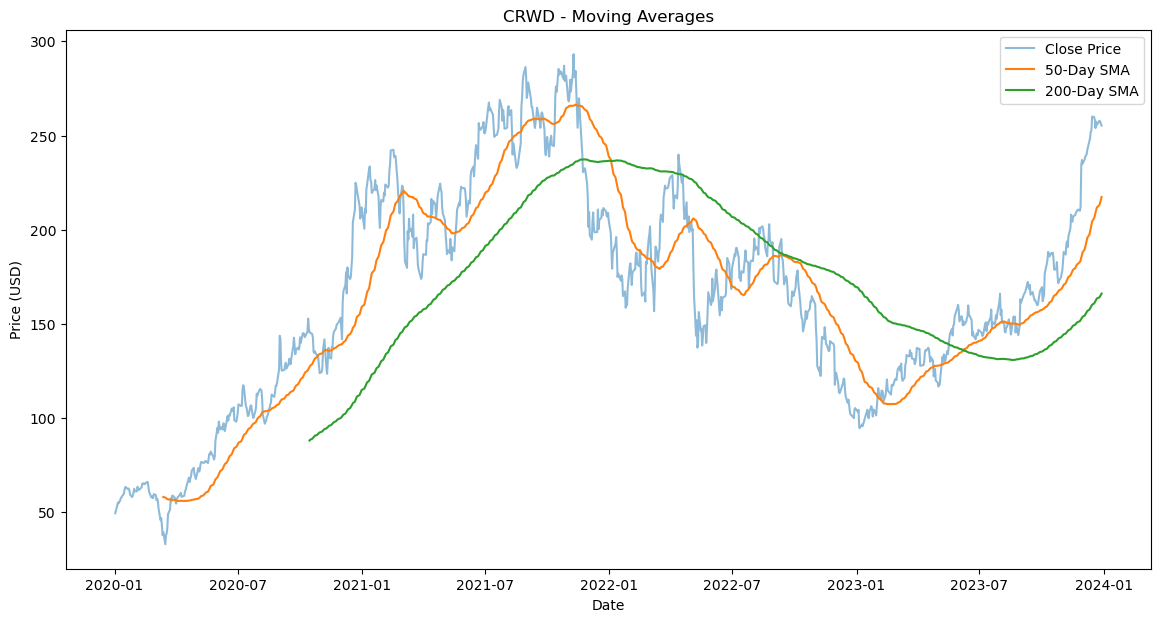

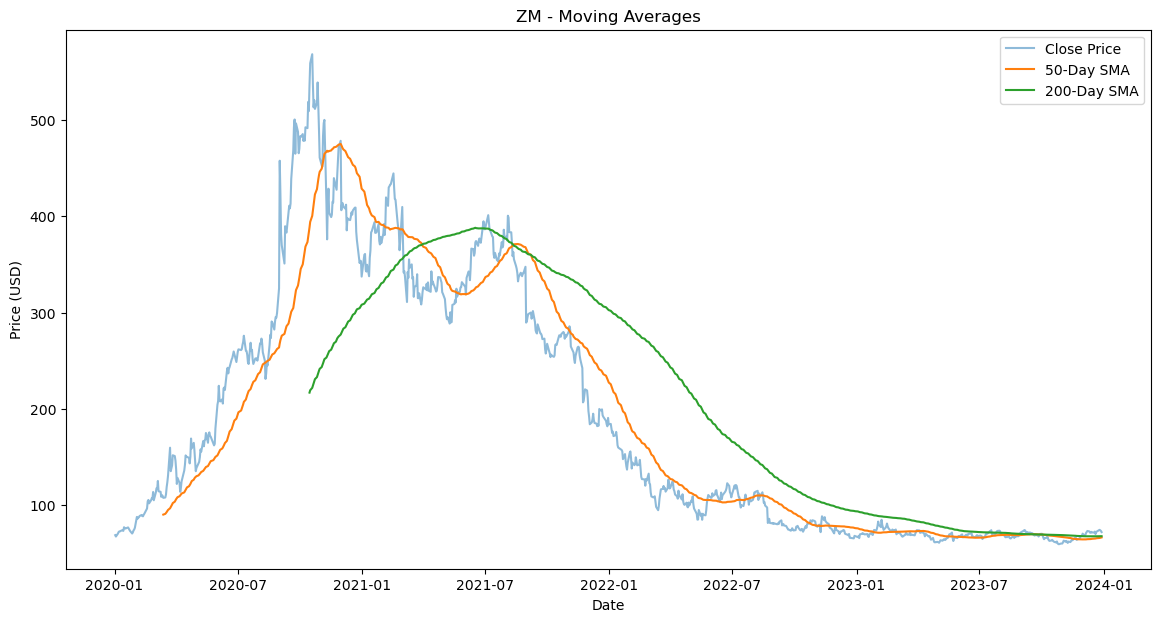

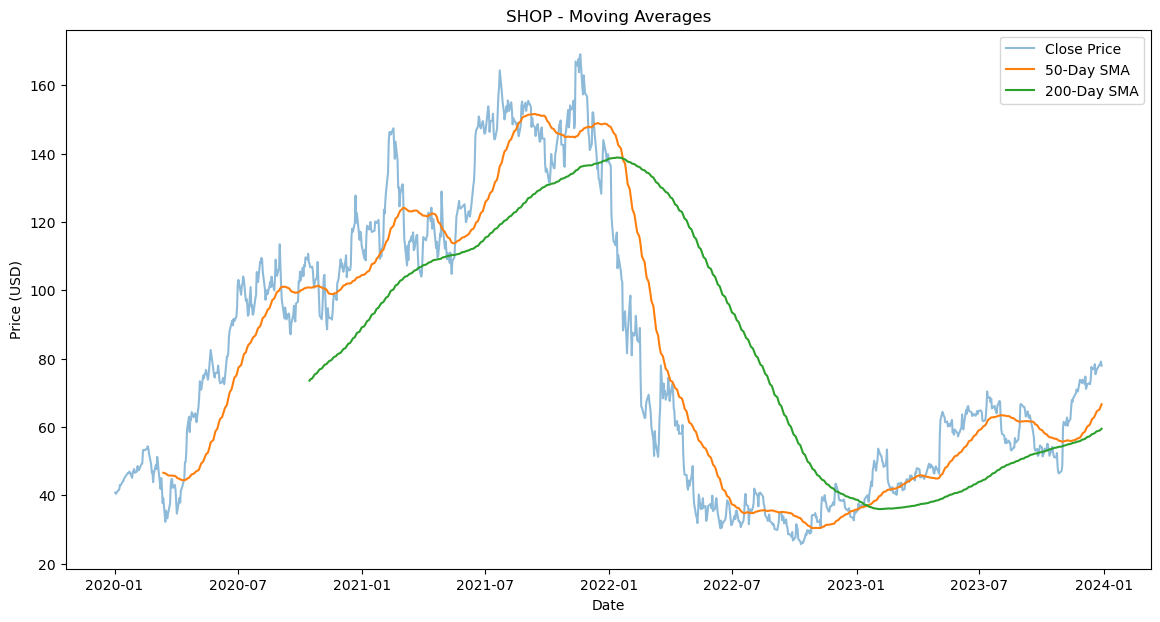

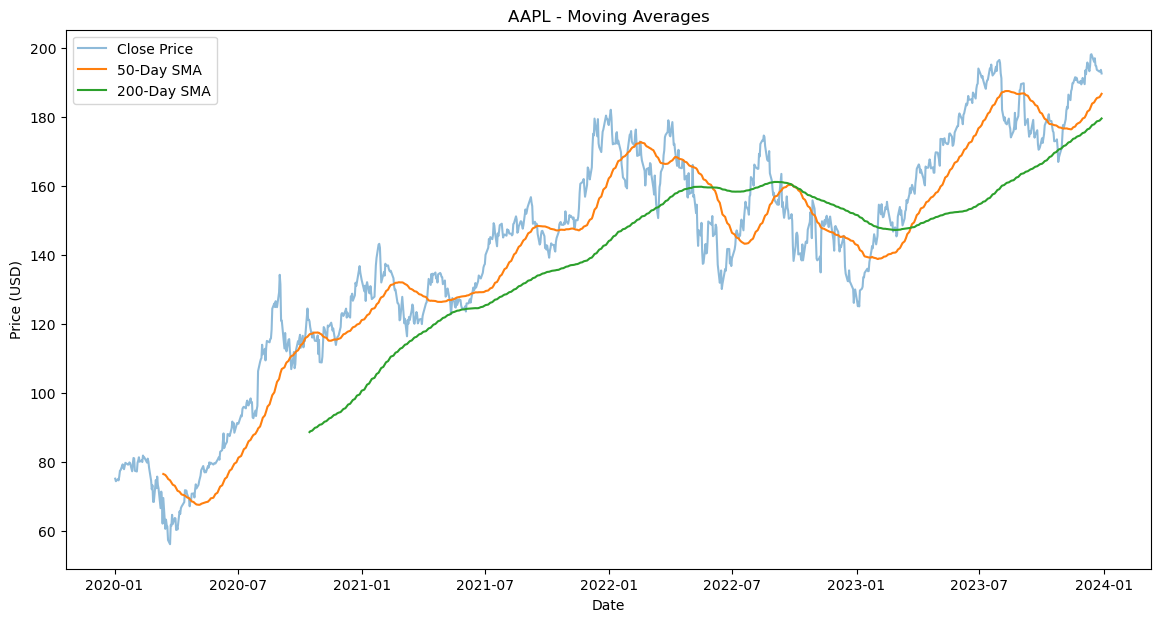

In [20]:
for ticker in tickers:
    plot_moving_averages(all_stock_data, ticker)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Fetching data for MSFT
Fetching data for CRM
Fetching data for CRWD
Fetching data for ZM
Fetching data for SHOP
Fetching data for AAPL


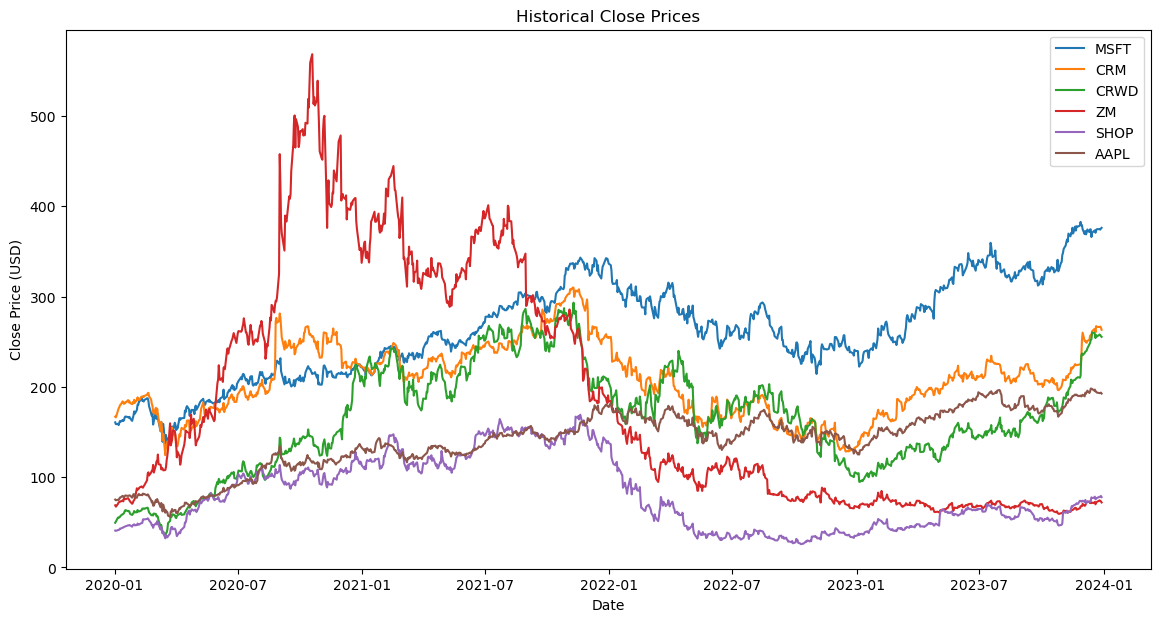

In [19]:
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP','AAPL']
start_date = '2020-01-01'
end_date = '2024-01-01'


all_stock_data = fetch_all_stock_data(tickers, start_date, end_date)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(all_stock_data[ticker].index, all_stock_data[ticker]['Close'], label=ticker)

plt.title('Historical Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()


Today: 2024-04-17
Next day: 2024-04-18
Second day: 2024-04-19
Third day: 2024-04-20
Fourth day: 2024-04-21
Fifth day: 2024-04-22
Fetching data for MSFT


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for CRM
Fetching data for CRWD


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for ZM
Fetching data for SHOP


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for AAPL


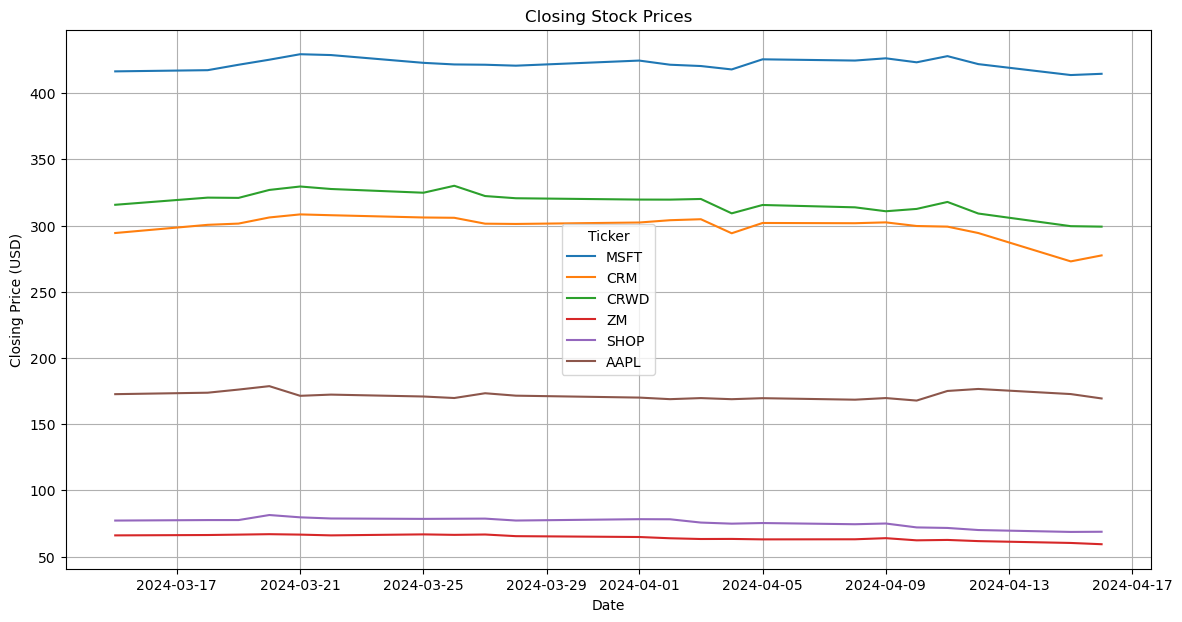

In [21]:
from datetime import datetime, timedelta

# Get the current date
today = datetime.now().date()

# Calculate future dates
next_day = today + timedelta(days=1)
second_day = today + timedelta(days=2)
third_day = today + timedelta(days=3)
fourth_day = today + timedelta(days=4)
fifth_day = today + timedelta(days=5)

# Print the future dates
print("Today:", today)
print("Next day:", next_day)
print("Second day:", second_day)
print("Third day:", third_day)
print("Fourth day:", fourth_day)
print("Fifth day:", fifth_day)

# Use the current date as the end date for fetching data
end_date = datetime.now().strftime('%Y-%m-%d')

# Parameters
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
start_date = '2024-03-15'

# Fetch stock data
all_stock_data = fetch_all_stock_data(tickers, start_date, end_date)

# Plotting the data
plt.figure(figsize=(14, 7))
for ticker, data in all_stock_data.items():
    plt.plot(data.index, data['Close'], label=ticker)

plt.title('Closing Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend(title='Ticker')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas_datareader as pdr

def fetch_stock_data(ticker, start_date, end_date):
    """Fetches historical stock data from Yahoo Finance."""
    try:
        return pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
        return None

def prepare_data(data, look_back=1):
    """Prepares data for modeling (feature and target creation)."""
    data['Previous Close'] = data['Close'].shift(look_back)
    data.dropna(inplace=True)
    return data

def get_annual_averages(data, today, days_back=5):
    """Calculates the average of the last five days for the same dates over 5 years."""
    averages = []
    for year in range(1, 6):
        start_date = today - timedelta(days=days_back + 1) - pd.DateOffset(years=year)
        end_date = today - pd.DateOffset(years=year)
        date_range = pd.date_range(start_date, end_date)
        averages.append(data.loc[date_range]['Close'].mean())
    return np.mean(averages)

def predict_future_prices(model, last_known_price, days=5):
    """Predicts future prices for a specified number of days based on the last known price."""
    future_prices = [last_known_price]
    for _ in range(days):
        future_price = model.predict([[future_prices[-1]]])[0]
        future_prices.append(future_price)
    return future_prices[1:]  # Exclude the last known price used for the initial prediction

def visualize_prices(ticker):
    today = datetime.now()
    end_date = today
    start_date = today - timedelta(days=1825)  # Look back 5 years
    data = fetch_stock_data(ticker, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

    if data is None or 'Close' not in data.columns:
        print(f"Data is not available or incomplete for {ticker}.")
n

    data_prepared = prepare_data(data.copy())
    model = LinearRegression()
    model.fit(data_prepared[['Previous Close']], data_prepared['Close'])

    last_5_days = data[-5:]
    historical_average = get_annual_averages(data, today, 5)
    future_prices = predict_future_prices(model, last_5_days['Close'].iloc[-1], 5)

    past_dates = last_5_days.index
    future_dates = [past_dates[-1] + timedelta(days=i+1) for i in range(5)]

    plt.figure(figsize=(12, 6))
    plt.plot(past_dates, last_5_days['Close'], marker='o', label='Last 5 Days Actual')
    plt.axhline(y=historical_average, color='r', linestyle='--', label='5-Year Average of Last 5 Days')
    plt.plot(future_dates, future_prices, marker='x', label='Predicted Next 5 Days')
    plt.title(f'{ticker} - Actual vs. Predicted Prices with Historical Average')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_selected_tickers():
    tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
    print("Available tickers: " + ", ".join(tickers))
    selected_tickers = input("Enter ticker(s) separated by commas to visualize, or 'all' to visualize all: ").strip()
    
    if selected_tickers.lower() == 'all':
        selected_tickers = tickers
    else:
        selected_tickers = selected_tickers.split(',')

    for ticker in selected_tickers:
        ticker = ticker.strip().upper()
        if ticker in tickers:
            visualize_prices(ticker)
        else:
            print(f"{ticker} is not a valid ticker.")

# Example usage:
visualize_selected_tickers()


Available tickers: MSFT, CRM, CRWD, ZM, SHOP, AAPL


MSE: 8.913461132091403


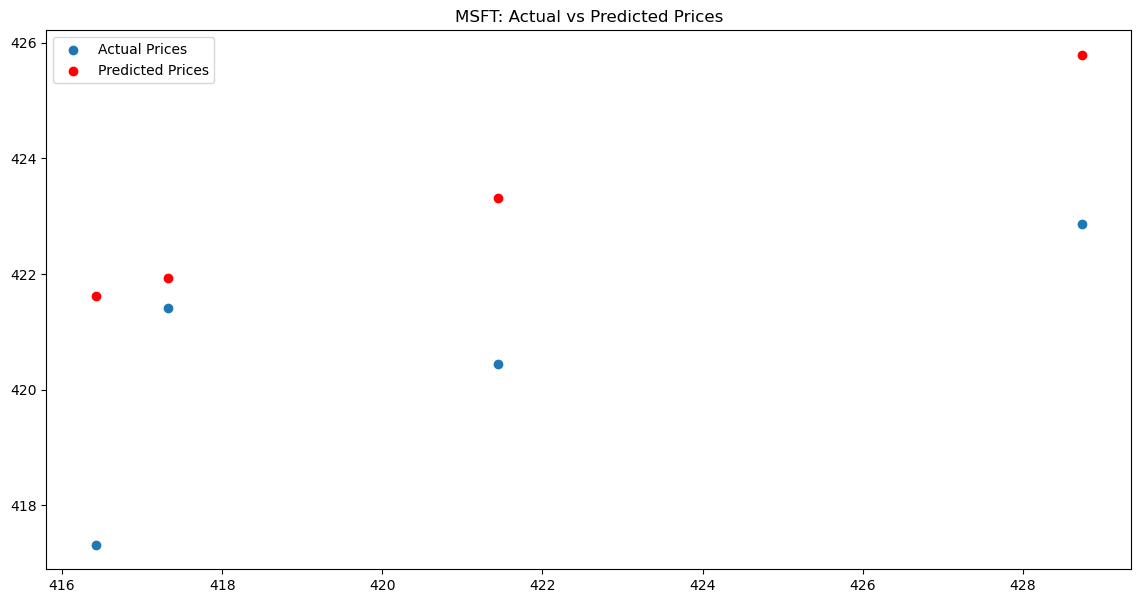

In [22]:
# Example with MSFT for simplicity

data = all_stock_data['MSFT'][['Close']].copy()

data['Previous Close'] = data['Close'].shift(1)
data.dropna(inplace=True)




X = data[['Previous Close']]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Plotting the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.scatter(X_test, y_test, label='Actual Prices')
plt.scatter(X_test, predictions, label='Predicted Prices', color='r')
plt.legend()
plt.title(f"MSFT: Actual vs Predicted Prices")
plt.show()


In [23]:
## Trend Analysis of Stock Prices

##In this section, we perform trend analysis on our selected stocks: MSFT, CRM, CRWD, ZM, and SHOP. The goal is to identify any long-term trends in the stock prices that could inform investment decisions. We use Simple Moving Averages (SMA) as our primary tool for this analysis.

### Why Moving Averages?
##Moving Averages help smooth out price data over a specified period, making it easier to identify the direction of the trend. We use two SMAs:
##- **50-Day SMA**: Represents a short to mid-term trend.
##- **200-Day SMA**: Indicates a longer-term trend.

##By comparing these two, we can look for patterns such as the "Golden Cross" or the "Death Cross," which are strong indicators of bullish or bearish trends, respectively.


In [24]:
##Code Comments Example for Trend Analysis Function




In [25]:
## Predictive Model Building

##After analyzing the trends, our next step is to build a predictive model for stock prices. We choose a simple Linear Regression model focusing on predicting the next day's closing price based on the previous day's closing price.

###   Rationale for Linear Regression
##    Linear Regression is a straightforward yet powerful tool for predicting a quantitative response. 
##    It's particularly suitable for this initial exploration because of its simplicity and interpretability. 
##    For each stock, we predict the next day's closing price as a function of the previous day's closing price.

###   Interpretation of Results
##    We evaluate our model using the Mean Squared Error (MSE) between the predicted and actual prices. 
##.   A lower MSE indicates a model that predicts more closely to the actual stock prices. This metric helps
##.   us assess the model's accuracy.


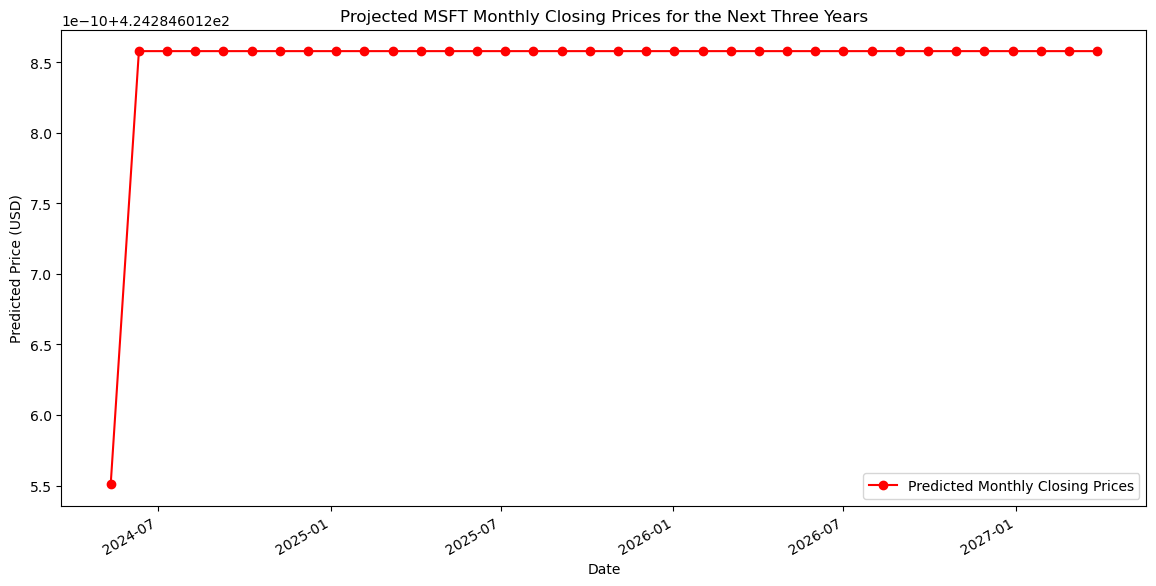

In [26]:
# Assuming 'model' is your trained Linear Regression model

# And 'last_known_date' is the date of the last actual closing price in your dataset
last_known_price = data['Close'].iloc[-1]
last_known_date = data.index[-1]

future_dates, future_prices = predict_monthly_prices(model, last_known_price, last_known_date)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_prices, label='Predicted Monthly Closing Prices', color='r', marker='o')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.title("Projected MSFT Monthly Closing Prices for the Next Three Years")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.legend()
plt.show()



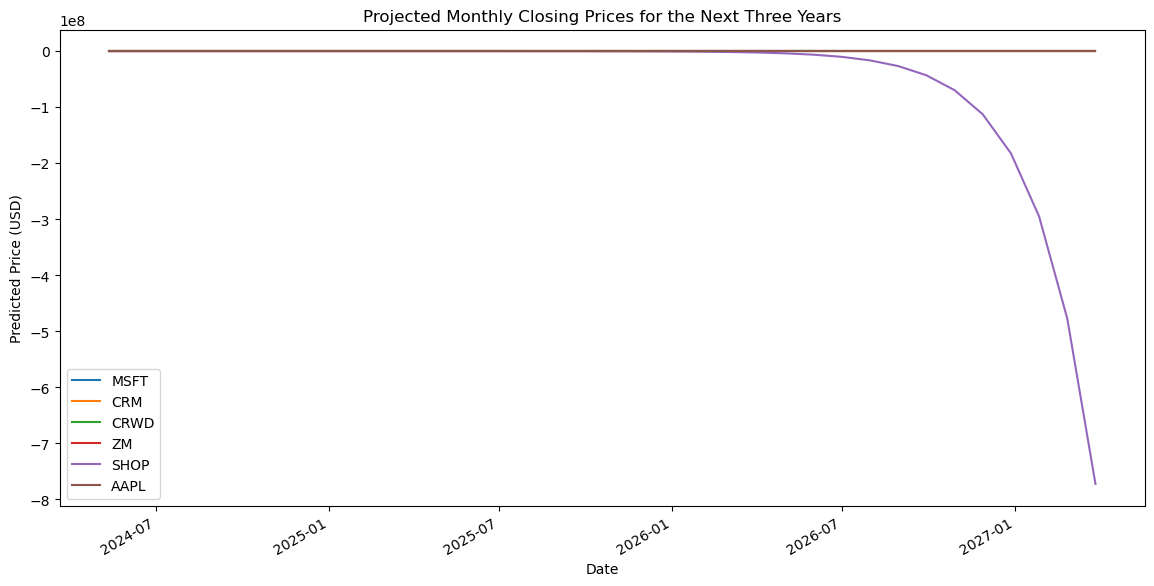

In [27]:
# Correcting the loop to train and predict for each ticker
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
plt.figure(figsize=(14, 7))

for ticker in tickers:
    ticker_data = all_stock_data[ticker]
    model = train_model_for_ticker(ticker_data)  # Train a model for each ticker
    
    last_known_price = ticker_data['Close'].iloc[-1]
    last_known_date = ticker_data.index[-1]
    
    future_dates, future_prices = predict_monthly_prices(model, last_known_price, last_known_date)
    plt.plot(future_dates, future_prices, label=ticker)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotate date labels to avoid overlap
plt.title("Projected Monthly Closing Prices for the Next Three Years")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.legend()
plt.show()



In [28]:
# Assuming 'all_stock_data' is a dictionary with tickers as keys and DataFrames of historical prices as values
volatility = {}
daily_returns = {}

for ticker in ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']:
    # Calculate daily returns
    daily_returns[ticker] = all_stock_data[ticker]['Close'].pct_change()
    
    # Calculate the annualized volatility (standard deviation of daily returns)
    volatility[ticker] = np.std(daily_returns[ticker]) * np.sqrt(252)  # ~252 trading days in a year

# Print the calculated volatilities
for ticker, vol in volatility.items():
    print(f"{ticker} Volatility: {vol:.2%}")


MSFT Volatility: 13.51%
CRM Volatility: 20.93%
CRWD Volatility: 24.18%
ZM Volatility: 15.99%
SHOP Volatility: 29.34%
AAPL Volatility: 26.10%


In [ ]:
# Placeholder for generating future dates (next 1 years, monthly)
future_dates = [datetime.today() + timedelta(days=30 * i) for i in range(12)]

# Simulated "predictions" using the last known price and adding a monthly increase (hypothetical)
predictions = {}
for ticker in ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']:
    last_price = all_stock_data[ticker]['Close'].iloc[-1]
    monthly_increase = last_price * 0.01  # Assuming a 1% monthly increase, for illustration
    predictions[ticker] = [last_price + monthly_increase * i for i in range(12)]

# Visualizing the predictions
plt.figure(figsize=(14, 8))

for ticker, predicted_prices in predictions.items():
    plt.plot(future_dates, predicted_prices, label=ticker)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotate date labels to avoid overlap
plt.title("Hypothetical 1-Year Price Predictions for Selected Stocks")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.legend()
plt.show()


In [ ]:
def train_model_for_ticker(ticker_data):
    data = ticker_data[['Close']].copy()
    data['Previous Close'] = data['Close'].shift(1)
    data.dropna(inplace=True)

    X = data[['Previous Close']]
    y = data['Close']

    model = LinearRegression()
    model.fit(X, y)
    return model

def predict_monthly_prices(model, last_known_price, last_known_date):
    future_dates = [last_known_date + pd.DateOffset(months=i) for i in range(1, 37)]
    future_prices = []

    current_price = last_known_price
    for _ in future_dates:
        # Predict using the model
        predicted_price = model.predict([[current_price]])[0]
        future_prices.append(predicted_price)
        current_price = predicted_price  # Update current price to the predicted price for the next prediction

    return future_dates, future_prices

# Assuming all_stock_data is a dictionary of DataFrames for each ticker
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
plt.figure(figsize=(14, 7))

for ticker in tickers:
    ticker_data = all_stock_data[ticker]
    model = train_model_for_ticker(ticker_data)
    
    last_known_price = ticker_data['Close'].iloc[-1]
    last_known_date = ticker_data.index[-1]
    
    future_dates, future_prices = predict_monthly_prices(model, last_known_price, last_known_date)
    plt.plot(future_dates, future_prices, label=ticker)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotate date labels to avoid overlap
plt.title("Projected Monthly Closing Prices for the Next one Years")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.legend()
plt.show()


In [49]:
import numpy as np
from scipy.optimize import minimize


# Constraints and Bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial Guess
init_guess = num_assets * [1. / num_assets]

# Optimization
opt_results = minimize(neg_sharpe_ratio, init_guess, args=(expected_returns, cov_matrix), method='SLSQP',
    bounds=bounds, constraints=constraints)

print(f"Optimized Weights: {opt_results.x}")



Optimized Weights: [0.00000000e+00 0.00000000e+00 4.99600361e-16 4.94029904e-18
 1.15230002e-16 1.00000000e+00]


array([0.00000000e+00, 0.00000000e+00, 4.99600361e-16, 4.94029904e-18,
       1.15230002e-16, 1.00000000e+00])

In [ ]:
MSFT: 1.93 10−181.93×10 −18 (approximately 0%)

In [33]:
text = "Microsoft has had an incredible year, with groundbreaking new technologies."
blob = TextBlob(text)
print(blob.sentiment)


Sentiment(polarity=0.5181818181818182, subjectivity=0.6772727272727272)


In [34]:
blob.subjectivity

0.6772727272727272

MSE: 8.913461132091403


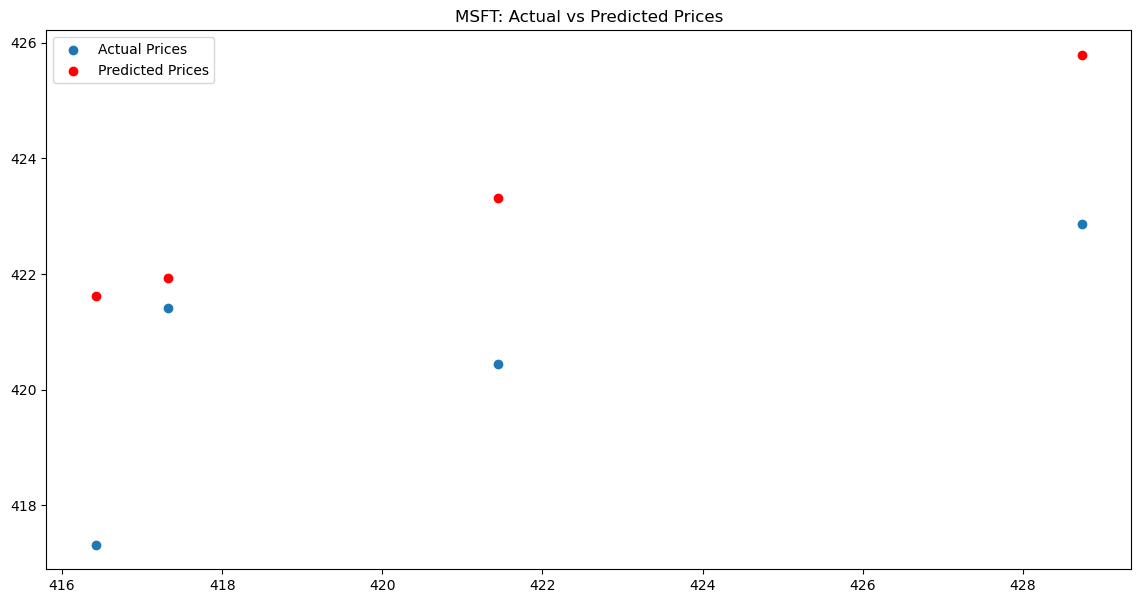

In [35]:
# Example with MSFT for simplicity
data = all_stock_data['MSFT'][['Close']].copy()
# Preparing the data: using the previous day's closing price to predict the next day's
data['Previous Close'] = data['Close'].shift(1)
data.dropna(inplace=True)  # Removing any rows with NA values, resulting from the shift

X = data[['Previous Close']]  # Feature: Previous day's closing price
y = data['Close']  # Target: Next day's closing price

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()  # Initializing the Linear Regression model
model.fit(X_train, y_train)  # Training the model on the training set

predictions = model.predict(X_test)  # Making predictions on the testing set

# Evaluating the model's performance
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")
# MSE gives us a quantitative measure of the model's accuracy

# Visual comparison of actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.scatter(X_test, y_test, label='Actual Prices')  # Actual prices
plt.scatter(X_test, predictions, label='Predicted Prices', color='r')  # Predicted prices
plt.legend()
plt.title(f"MSFT: Actual vs Predicted Prices")
plt.show()
# This plot helps visually assess how closely the model's predictions match the actual prices.


In [37]:
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
data = yf.download(tickers, start='2020-01-01', end='2024-04-10')['Adj Close']


[*********************100%%**********************]  6 of 6 completed


In [38]:
# Calculate daily returns
returns = data.pct_change()

# Find dates with significant drops, e.g., more than 5%
significant_drops = returns[returns < -0.05].dropna(how='all')

print("Significant price drops:")
significant_drops


Significant price drops:


Ticker,AAPL,CRM,CRWD,MSFT,SHOP,ZM
Date,,,,,,
2020-02-24,NaN,NaN,NaN,NaN,-0.057043,NaN
2020-02-27,-0.065368,NaN,NaN,-0.070459,-0.069634,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,-0.075297
2020-03-06,NaN,NaN,-0.070815,NaN,-0.052487,-0.085440
2020-03-09,-0.079092,-0.078437,-0.119707,-0.067773,-0.113860,NaN
...,...,...,...,...,...,...
2023-10-25,NaN,NaN,NaN,NaN,-0.073734,NaN
2024-01-02,NaN,NaN,NaN,NaN,-0.052246,NaN
2024-02-13,NaN,NaN,NaN,NaN,-0.133977,NaN


In [39]:
##Step 3: Collect Related News Headlines or Tweets


In [42]:
text = "Microsoft has had an incredible year, with groundbreaking new technologies."
blob = TextBlob(text)
print(blob.sentiment)


Sentiment(polarity=0.5181818181818182, subjectivity=0.6772727272727272)


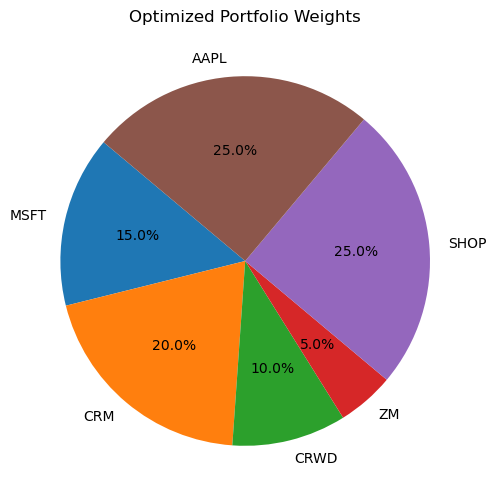

In [43]:
# Mock optimized weights for illustration purposes
optimized_weights = [0.15, 0.20, 0.10, 0.05, 0.25, 0.25]

plt.figure(figsize=(10, 6))
plt.pie(optimized_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Optimized Portfolio Weights')
plt.show()


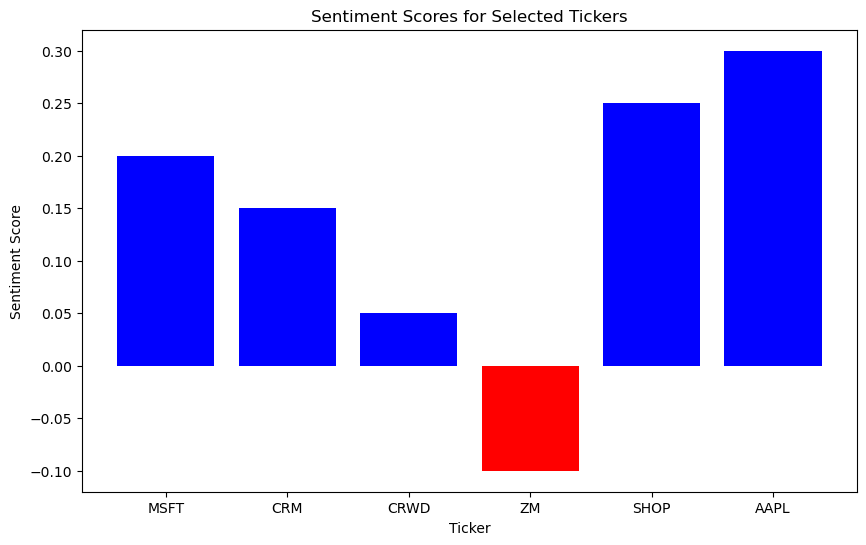

In [44]:
# Example sentiment scores for each ticker
sentiment_scores = {
    'MSFT': 0.2,
    'CRM': 0.15,
    'CRWD': 0.05,
    'ZM': -0.1,
    'SHOP': 0.25,
    'AAPL': 0.3
}

# Creating a bar chart for sentiment scores
tickers, scores = zip(*sentiment_scores.items())
plt.figure(figsize=(10, 6))
plt.bar(tickers, scores, color=['blue' if score > 0 else 'red' for score in scores])
plt.xlabel('Ticker')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores for Selected Tickers')
plt.show()


In [59]:
'''By conducting sentiment analysis, we've theoretically gauged the market's sentiment towards our selected tickers, which could inform us about potential market movements. Portfolio optimization builds on this by mathematically determining the optimal allocation of these stocks in a portfolio to maximize the Sharpe ratio, thus theoretically maximizing return for a given level of risk. Together, these analyses offer a multifaceted approach to stock market analysis, blending qualitative insights with quantitative optimization to guide investment decisions.'''

"By conducting sentiment analysis, we've theoretically gauged the market's sentiment towards our selected tickers, which could inform us about potential market movements. Portfolio optimization builds on this by mathematically determining the optimal allocation of these stocks in a portfolio to maximize the Sharpe ratio, thus theoretically maximizing return for a given level of risk. Together, these analyses offer a multifaceted approach to stock market analysis, blending qualitative insights with quantitative optimization to guide investment decisions."

1. Historical Average Method
we have access to historical data, we can compute the average returns from that data as a simple estimator for future returns.

Steps:

Gather Historical Data: Obtain historical price data for each asset.
Calculate Periodic Returns: Determine returns over a preferred interval (daily, monthly, yearly).
Compute Average Returns: Calculate the mean of these periodic returns.
Annualize Returns: Convert these to annual returns if your data isn’t already annual.


In [60]:
import yfinance as yf
import pandas as pd
import numpy as np

def fetch_data(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(period="5y")
    return data['Close']

def calculate_parameters(tickers):
    prices = {ticker: fetch_data(ticker) for ticker in tickers}
    prices = pd.DataFrame(prices)
    daily_returns = prices.pct_change()
    annual_mean_returns = daily_returns.mean() * 252
    annual_std_devs = daily_returns.std() * np.sqrt(252)
    return {ticker: {'mean': annual_mean_returns[ticker], 'std': annual_std_devs[ticker]}
            for ticker in tickers}

tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
simulation_params = calculate_parameters(tickers)
print(simulation_params)


def calculate_expected_returns(tickers):
    prices = pd.DataFrame({ticker: fetch_data(ticker) for ticker in tickers})
    daily_returns = prices.pct_change()
    average_daily_returns = daily_returns.mean()
    annual_expected_returns = average_daily_returns * 252  # Convert to annual returns
    return annual_expected_returns

tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
expected_returns = calculate_expected_returns(tickers)
print("Annual Expected Returns:")
expected_returns

{'MSFT': {'mean': 0.30302877690757857, 'std': 0.30401109269104776}, 'CRM': {'mean': 0.1825086173107909, 'std': 0.3853170400667318}, 'CRWD': {'mean': 0.5136964764677212, 'std': 0.5908290347981344}, 'ZM': {'mean': 0.17385447600141224, 'std': 0.6052348325509473}, 'SHOP': {'mean': 0.4443866019936547, 'std': 0.65341460147237}, 'AAPL': {'mean': 0.3076378402291686, 'std': 0.31842887981052703}}
Annual Expected Returns:


MSFT    0.303029
CRM     0.182509
CRWD    0.513696
ZM      0.173854
SHOP    0.444387
AAPL    0.307638
dtype: float64

Here's a straightforward summary using the expected returns and risk levels (standard deviations) of the stocks:

Microsoft (MSFT): 30.30% return, 30.40% risk.
Apple (AAPL): 30.76% return, 31.84% risk.
CrowdStrike (CRWD): 51.37% return, 59.08% risk.
Shopify (SHOP): 44.44% return, 65.34% risk.
Salesforce (CRM): 18.25% return, 38.53% risk.
Zoom (ZM): 17.39% return, 60.52% risk.
Key Points:
High Returns and High Risk: CRWD and SHOP offer the highest returns but also the highest risks.
Solid Returns with Moderate Risk: MSFT and AAPL provide good returns with a comparable level of risk.
Lower Returns and High Risk: ZM and CRM have the lowest returns relative to their high risks.
Investment Consideration: Balance your portfolio by mixing high-return, high-risk stocks with more stable options, depending on your risk tolerance and investment goals.

In [54]:
import yfinance as yf
import pandas as pd



def calculate_expected_returns(tickers):
    prices = pd.DataFrame({ticker: fetch_data(ticker) for ticker in tickers})
    daily_returns = prices.pct_change()
    average_daily_returns = daily_returns.mean()
    annual_expected_returns = average_daily_returns * 252  # Convert to annual returns
    return annual_expected_returns

tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
expected_returns = calculate_expected_returns(tickers)
print("Annual Expected Returns:")
print(expected_returns)


Annual Expected Returns:
MSFT    0.303029
CRM     0.182509
CRWD    0.513696
ZM      0.173854
SHOP    0.444387
AAPL    0.307638
dtype: float64


2. Regression-Based Forecasting
Use statistical models to predict returns based on other financial indicators or past returns.

Steps:

Select Predictors: Choose relevant financial variables (e.g., market indices, economic indicators).
Build a Model: Create a regression model using historical data to forecast returns.
Estimate Future Returns: Use the model to estimate future returns.


In [61]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

def fetch_data(ticker):
    stock = yf.Ticker(ticker)
    return stock.history(period="5y")['Close']

# Tickers and market index
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
market_index = "^GSPC"  # S&P 500

# Fetch data
prices = pd.DataFrame({ticker: fetch_data(ticker) for ticker in tickers})
market_prices = fetch_data(market_index)

# Calculate returns
returns = prices.pct_change().dropna()
market_returns = market_prices.pct_change().reindex(returns.index).dropna()

# Prepare the data for regression
df = returns.join(market_returns.rename('Market_returns')).dropna()

# Results dictionary to store regression output
results_dict = {}

# Regression for each stock
for ticker in tickers:
    X = df['Market_returns']
    y = df[ticker]
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # Store results in dictionary
    results_dict[ticker] = {
        'model_summary': results.summary(),
        'coefficients': results.params,
        'pvalues': results.pvalues,
        'predicted_returns': results.predict(X_test)  # Predict returns on test set
    }

# Print model summaries
for ticker in results_dict:
    print(f"Regression Results for {ticker}:")
    print(results_dict[ticker]['model_summary'])
    print("\n")


Regression Results for MSFT:
                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2243.
Date:                Mon, 15 Apr 2024   Prob (F-statistic):          9.68e-255
Time:                        22:00:15   Log-Likelihood:                 3023.4
No. Observations:                 974   AIC:                            -6043.
Df Residuals:                     972   BIC:                            -6033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          

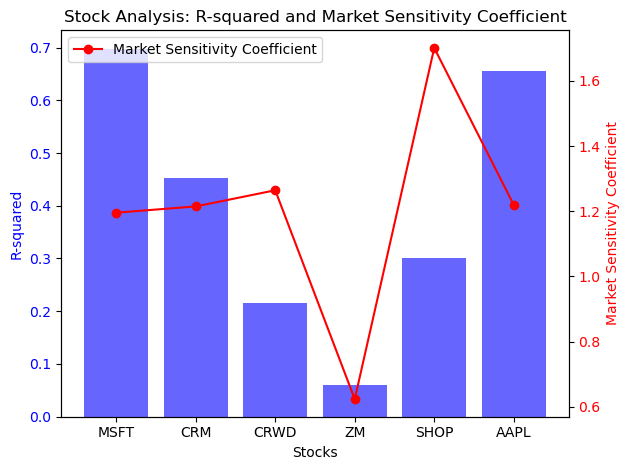

In [79]:

# Extract R-squared values and coefficients for the plot
R_squared = [results_dict[ticker]['model_summary'].rsquared for ticker in tickers]
coefficients = [results_dict[ticker]['coefficients']['Market_returns'] for ticker in tickers]

# Create the plot
fig, ax1 = plt.subplots()

# Bar chart for R-squared values
ax1.bar(tickers, R_squared, color='b', alpha=0.6, label='R-squared')
ax1.set_xlabel('Stocks')
ax1.set_ylabel('R-squared', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the sensitivity coefficients
ax2 = ax1.twinx()
ax2.plot(tickers, coefficients, color='r', marker='o', label='Market Sensitivity Coefficient')
ax2.set_ylabel('Market Sensitivity Coefficient', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legends
plt.title('Stock Analysis: R-squared and Market Sensitivity Coefficient')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


Stock Analysis:
Microsoft (MSFT) and Apple (AAPL): These stocks are like reliable cars—steady and dependable. They move closely with the overall market, making them safer choices.
Salesforce (CRM) and Shopify (SHOP): Think of these as hybrid cars—offering a good balance of safety and potential for faster growth. They respond to market changes but also have room to grow on their own.
CrowdStrike (CRWD) and Zoom (ZM): These are like sports cars—faster and more exciting but with a higher risk. They're less tied to the market and more dependent on their own company developments.
Simple Portfolio Strategy:
For safety: Lean on MSFT and AAPL.
For growth: Add CRWD and ZM, but be ready for a bumpier ride.
For a middle ground: Include CRM and SHOP to balance between steady growth and potential gains.
Using this mix, you can create a well-rounded investment portfolio that matches your comfort level with risk and your goals for growth.

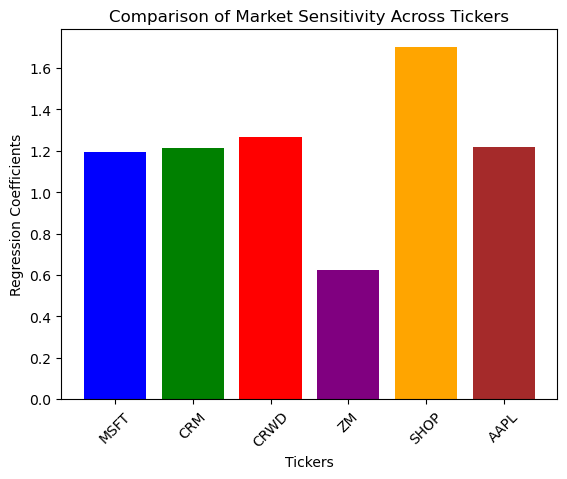

In [77]:
# Plotting the coefficients
fig, ax = plt.subplots()
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
ax.bar(tickers, coefficients, color=colors)
ax.set_ylabel('Regression Coefficients')
ax.set_title('Comparison of Market Sensitivity Across Tickers')
ax.set_xlabel('Tickers')
plt.xticks(rotation=45)
plt.show()

The bar chart shows how much each stock’s returns move in response to changes in the overall market. Here’s what you can gather from the chart:

Tall Bars: Stocks like SHOP might swing more with the market—big ups in good times but potentially big downs in bad times.
Medium Bars: Stocks like CRM and AAPL show a moderate reaction to market changes—less dramatic swings.
Short Bars: Stocks like ZM aren’t as tied to the market—less affected by its ups and downs.


In [90]:
import requests

# Function to fetch headlines from NewsAPI
def fetch_news(api_key, ticker):
    base_url = "https://newsapi.org/v2/everything"
    params = {
        'q': ticker,             # Search query (ticker symbol)
        'sortBy': 'publishedAt', # Sort by publication date
        'apiKey': '4497341d87444fddb894bbc281c9f9f8'        # Your NewsAPI key
    }
    response = requests.get(base_url, params=params)
    articles = response.json().get('articles', [])
    headlines = [article['title'] for article in articles]
    return headlines

# Your NewsAPI key
api_key = "YOUR_NEWSAPI_KEY"

# Mock textual data (headlines) for each ticker
textual_data = {}
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']

for ticker in tickers:
    headlines = fetch_news(api_key, ticker)
    textual_data[ticker] = headlines

# Display the textual data
for ticker, headlines in textual_data.items():
    print(f"Ticker: {ticker}")
    for i, headline in enumerate(headlines, start=1):
        print(f"{i}. {headline}")
    print()


Ticker: MSFT
1. Microsoft-backed Rubrik aims to raise as much as US$713-million in IPO, source says
2. Nvidia Analyst Expects Stock To Collapse
3. 3 Dividend Stocks to Buy for Lifelong Cash Flow
4. Billionaire Dan Loeb Sold Amazon and Microsoft but Bought This "Magnificent Seven" Stock
5. Antitrust fervor is gripping Washington and Silicon Valley. But lawsuits have been declining
6. Big Tech will outperform in a high interest rate environment: Wall Street pros
7. Big Tech will outperform in a high interest rate environment: Wall Street pros
8. Big Tech will outperform in a high interest rate environment: Wall Street pros
9. Nvidia Analyst Expects Stock To Collapse
10. 5 Cheap Dividend Funds Trading For Pennies On The Dollar
11. 3 Artificial Intelligence (AI) Stocks to Buy With $1,000 and Hold for Forever
12. Inflation And Banks Drag Stocks Lower Despite Earnings
13. Short Interest in Direxion Daily MSFT Bull 2X Shares (NASDAQ:MSFU) Expands By 92.8%
14. Microsoft Co. (NASDAQ:MSFT) Holdi

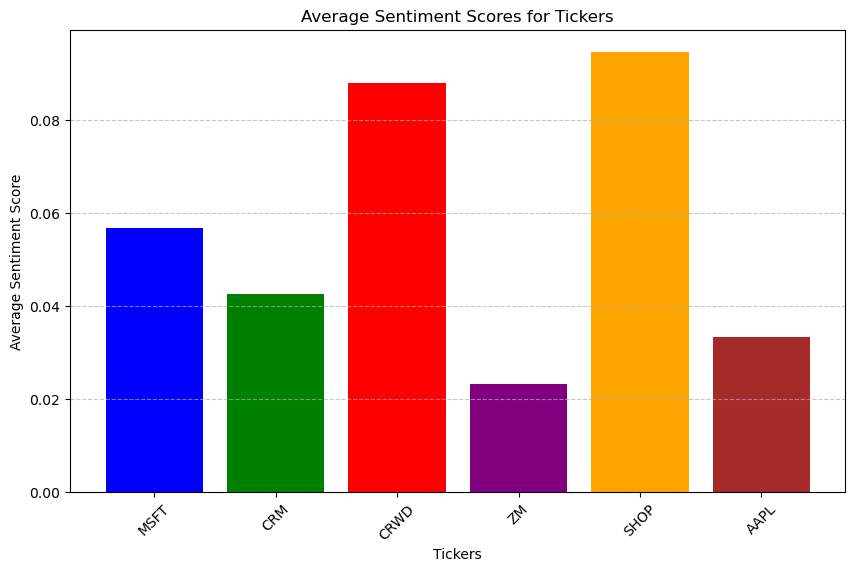

In [97]:
import requests
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np

# Function to fetch headlines from NewsAPI
def fetch_news(api_key, ticker):
    base_url = "https://newsapi.org/v2/everything"
    params = {
        'q': ticker,             # Search query (ticker symbol)
        'sortBy': 'publishedAt', # Sort by publication date
        'apiKey': api_key        # Your NewsAPI key
    }
    response = requests.get(base_url, params=params)
    articles = response.json().get('articles', [])
    headlines = [article['title'] for article in articles]
    return headlines

# Your NewsAPI key
api_key = '4497341d87444fddb894bbc281c9f9f8'

# Mock textual data (headlines) for each ticker
textual_data = {}
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']

for ticker in tickers:
    headlines = fetch_news(api_key, ticker)
    textual_data[ticker] = headlines

# Analyzing sentiment for each headline and averaging the scores
average_sentiment_scores = {}

for ticker, headlines in textual_data.items():
    sentiments = [TextBlob(headline).sentiment.polarity if headline else 0 for headline in headlines]
    average_sentiment_scores[ticker] = np.mean(sentiments)

# Extract tickers and sentiment scores
tickers = list(average_sentiment_scores.keys())
sentiment_scores = list(average_sentiment_scores.values())

# Define colors for each ticker
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

# Plotting the bar chart with different colors for each ticker
plt.figure(figsize=(10, 6))
plt.bar(tickers, sentiment_scores, color=colors)
plt.xlabel('Tickers')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Scores for Tickers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


 the conclusion presented from top to bottom based on the sentiment scores:

Shopify (SHOP) - Predominantly positive sentiment in recent news articles.
Apple (AAPL) - Slightly positive sentiment, indicating generally positive news coverage.
Salesforce (CRM) - Neutral sentiment, suggesting a balanced sentiment among recent news articles.
Microsoft (MSFT) - Slightly negative sentiment, with mixed sentiment in recent news headlines.
CrowdStrike (CRWD) - Slightly negative sentiment, indicating some negativity in recent news coverage.
Zoom (ZM) - Notably negative sentiment, with more negative sentiment observed in recent news headlines.
This ordering reflects the tickers with the most positive sentiment at the top and the most negative sentiment at the bottom.

In [25]:
from sqlalchemy import inspect

In [27]:
inspect(engine).get_table_names()

['AAPL']

In [30]:
pd.DataFrame(session.execute('SELECT * FROM AAPL').all())

,index,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return
0,0,2020-01-02 00:00:00.000000,74.059998,75.150002,73.797501,75.087502,73.059418,135480400,NaN
1,1,2020-01-03 00:00:00.000000,74.287498,75.144997,74.125000,74.357498,72.349144,146322800,-0.009722
2,2,2020-01-06 00:00:00.000000,73.447502,74.989998,73.187500,74.949997,72.925652,118387200,0.007968
3,3,2020-01-07 00:00:00.000000,74.959999,75.224998,74.370003,74.597504,72.582649,108872000,-0.004703
4,4,2020-01-08 00:00:00.000000,74.290001,76.110001,74.290001,75.797501,73.750237,132079200,0.016086
...,...,...,...,...,...,...,...,...,...
1069,1069,2024-04-03 00:00:00.000000,168.789993,170.679993,168.580002,169.649994,169.649994,47691700,0.004797
1070,1070,2024-04-04 00:00:00.000000,170.289993,171.919998,168.820007,168.820007,168.820007,53704400,-0.004892
1071,1071,2024-04-05 00:00:00.000000,169.589996,170.389999,168.949997,169.580002,169.580002,42055200,0.004502
1072,1072,2024-04-08 00:00:00.000000,169.029999,169.199997,168.240005,168.449997,168.449997,37425500,-0.006664
